
# Radar observation : radar quality code

The aim of this notebook is to help read you the quality code data of the rainfall product.

**/!\ The quality code data samples contain only 3 days of data (and not 10 or 11 days) because the original data are too large for GitHub.**

For each radar data type, you will find one archive per year and per zone, each one sliced in periods of 10 or 11 days (each month is separated in 3 files). 

Each `.npz` file contains 3 arrays :

* `data` : an array containing maps of radar data values.

* `dates` : an array containing a datetime object and indicating the date of each `data` map.

* `miss_dates` : an array containing a datetime object for each missing radar map over the period.

Here, the `data` array contains a radar quality code for each time step. For each pixel, the value ranges between 0 (very bad) and 100 (perfect), the unit is the percent. If the value is missing, then the value is 255. 

The original data was to heavy to be manipulated so the quality code data are divided into 2 files :

* `rainfall_mean_quality_DATE.npz` contains the quality code's average over a day and for each pixel.
  
* `rainfall_diff_quality_DATE.npz` contains the difference between the original value and the average over the day for each pixel.

The time step between two radar scans is 5 min. The radar starts scanning at 00h every day and ends at 23h55. So each file of 11 days should contain a maximum of 3168 rainfall maps (minus the missing dates).

The radar's spatial resolution is 0.01° and the projection system used is EPSG:4326.

You will also find a `radar_coords_ZONE.npz` file containing 2 arrays `lats` and `lons`, indicating the coordinates (latitude and longitude) of the center of each radar pixel.

For more information, cf [documentation](https://meteofrance.github.io/meteonet/english/data/rain-radar/).

# Quickstart

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors

First, let's select the zone and date we want to study : 

In [2]:
zone = "NW"    # NW or SE
year = 2016    # 2016, 2017 or 2018
month = 8
part_month = 3 # Choice between 1,2,3, as we said earlier each month is divided in 3 parts

Now, we load the data and the coordinates :

In [3]:
directory = "../../data_samples/radar/"
fname_mean = directory + f'rainfall_mean_quality-code_{zone}_{str(year)}_{str(month).zfill(2)}.{str(part_month)}.npz'
fname_diff = directory + f'rainfall_diff_quality-code_{zone}_{str(year)}_{str(month).zfill(2)}.{str(part_month)}.npz'
fname_coords = directory + f'radar_coords_{zone}.npz'

array_mean = np.load(fname_mean, allow_pickle=True)
array_diff= np.load(fname_diff, allow_pickle=True)
data_mean = array_mean['data']
dates_mean = array_mean['dates']
miss_dates_mean = array_mean['miss_dates']
data_diff = array_diff['data']
dates_diff = array_diff['dates']
miss_dates_diff = array_diff['miss_dates']

coords = np.load(fname_coords, allow_pickle=True)
#it is about coordinates of the center of pixels
lat = coords['lats']
lon = coords['lons']

Compute the real values : mean + diff

In [4]:
data = np.zeros(data_diff.shape,dtype=np.int16) 
d = np.asarray([dd.day for dd in dates_diff])
m = np.asarray([dm.day for dm in dates_mean])
for date in dates_mean:
    day = date.day
    i_min = np.where(d==day)[0][0]
    i_max = np.where(d==day)[0][len(np.where(d==day)[0])-1]
    data[i_min:i_max+1,:,:] = data_mean[m==day] + data_diff[d==day]
    data[data_diff==255] = 255  #put 255 for the missing values 

Plot some examples :

<IPython.core.display.Javascript object>


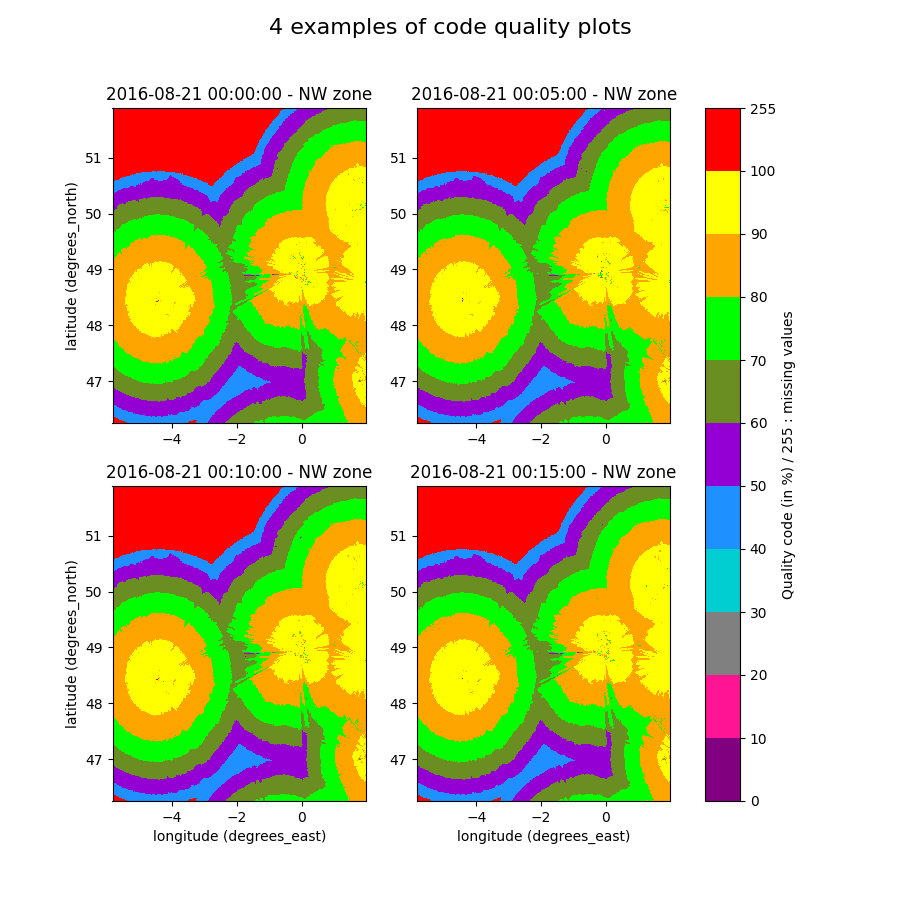

/opt/anaconda3/envs/preproc/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':
/opt/anaconda3/envs/preproc/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/opt/anaconda3/envs/preproc/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dime

In [5]:
dates = dates_diff
title = "4 examples of code quality plots"
fig, ax = plt.subplots(2, 2,figsize=(9,9))
fig.suptitle(title, fontsize=16)

# Colormap definition
cmap = colors.ListedColormap(['purple', 'deeppink', 'grey','darkturquoise', 'dodgerblue',
                              'darkviolet','olivedrab','lime','orange','yellow','red'])
bounds = [0,10,20,30,40,50,60,70,80,90,100,255]
norm = colors.BoundaryNorm(bounds, cmap.N)

pl=ax[0,0].pcolormesh(lon, lat, data[0,:,:],cmap=cmap, norm=norm)
ax[0,0].set_ylabel('latitude (degrees_north)')
ax[0,0].set_title(str(dates[0]) + " - "+  zone + " zone")

pl=ax[0,1].pcolormesh(lon, lat, data[1,:,:],cmap=cmap, norm=norm)
ax[0,1].set_title(str(dates[1]) + " - "+  zone + " zone")

pl=ax[1,0].pcolormesh(lon, lat, data[2,:,:],cmap=cmap, norm=norm)
ax[1,0].set_xlabel('longitude (degrees_east)')
ax[1,0].set_ylabel('latitude (degrees_north)')
ax[1,0].set_title(str(dates[2]) + " - "+  zone + " zone")

pl=ax[1,1].pcolormesh(lon, lat, data[3,:,:],cmap=cmap, norm=norm)
ax[1,1].set_xlabel('longitude (degrees_east)')
ax[1,1].set_title(str(dates[3]) + " - "+  zone + " zone")

# Plot the color bar
cbar = fig.colorbar(pl,ax=ax.ravel().tolist(),cmap=cmap, norm=norm, boundaries=bounds, 
                ticks=bounds, orientation= 'vertical').set_label('Quality code (in %) / 255 : missing values')
plt.show()

## Exploring the data

### Mean - Data

Dimensions of the ```data_mean``` array: 

* Number of days with available records

* Number of points on the y axis : latitude

* Number of points on the x axis : longitude

In [ ]:
data_mean.shape

### Mean - Dates

Dimension of the ```dates_mean``` array: 

* Number of days with available records

In [ ]:
dates_mean

### Mean - Missing dates

Dimension of the ```miss_dates_mean``` array: 

* Number of days with any record

In [ ]:
miss_dates_mean.shape

### Data

Dimensions of the ```data``` array: 

* Number of records : the radar records a scan every 5 min

* Number of points on the y axis : latitude

* Number of points on the x axis : longitude

In [ ]:
data.shape

### Longitude

In [ ]:
lon.shape

In [ ]:
lon

# Plot with Cartopy

In [ ]:
from meteonet_toolbox.constant import DOMAINS
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
#coordinates of study zone boundaries
lllat=DOMAINS[zone]['lry']    #lower left latitude
urlat=DOMAINS[zone]['uly']    #upper right latitude
lllon=DOMAINS[zone]['ulx']    #lower left longitude
urlon=DOMAINS[zone]['lrx']    #upper right longitude
extent = [lllon, urlon, lllat, urlat]

Plot the quality code values for 1 given time step

In [ ]:
fig = plt.figure(figsize=(9,10))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
plt.imshow(data[0], interpolation='none', origin='upper',cmap=cmap, norm=norm, extent=extent)

# Add coastlines and borders
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Show only the area we defined
ax.set_extent(extent)

# Add the colorbar
plt.colorbar(cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, 
             orientation= 'horizontal').set_label('Rainfall (in 1/100 mm) / -1 : missing values')
plt.title("Rainfalls - "+ str(dates[0]) + " - "+  zone + " zone")
plt.show()